# Mapping surface height dynamics to subsurface flow physics in free-surface turbulent flow using SHRED - Code tutorial

This notebook illustrates step-by-step how the results and plots are generated. The notebook runs all the necessary plots, given the folder structure, and files, are correctly set up. This Notebook uses functions and programs that are saved in .py files. For details behind the results, check out these files.

Note, the pre-processing of datasets, especially for big datasets like the DNS, takes time and a lot of space. Do this once and save files in the correct folder. 

# Loading files and libraries

In [1]:
import numpy as np
import processdata       #this file contains all function for the processing, including how to run SHRED, calculate error metrics
import plot_results   #file with plotting functions
import utilities        #file with different utility functions
import models           #file includes the SHRED model


# Pre-processing, loading data files etc

Before starting, we must ensure all data is loaded correctly. Data from the DNS cases and the experimental cases from the so-called 'T-tank' are saved locally. These should be stored in /data/DNS/raw/ or /data/exp/raw/. 

### DNS
For the DNS data, each horizontal velocity plane, as well as surface profilometry, is stored as one .mat file each, as an array of shape (dimX, dimY, dimT), where X and Y are spatial dimensions, and T is time. 

In [ ]:
'''READING DNS DATA'''

#DNS_case = 'RE1000' #corresponds to case S1
DNS_case = 'RE2500' #corresponds to case S2

#specify plane (1=surface, 1> subsurface)
plane = 1 # 1-55 for S1, 1-76 for S2

#specify address: if not given, it will be stored under data/DNS/raw/



#reading u_fluc, the velocity fluctuation, of the given velocity plane
u_fluc = utilities.get_velocity_plane_DNS(DNS_case, plane)


#get surface elevation

surf_fluc = utilities.get_surface_DNS(DNS_case)

### Experiment
For the experimental data, we assume all files in .mat file. In the case of the experimental 'T-tank' data, there are 5 PIV velocity planes, named [H395, H390, H375, H350, H300], where the number represents the mm height from a reference level, and surface reference is at 400 mm, i.e. H390 is 1 cm below surface, H300 is 10 cm below surface.  Note that only the last 4 are used, as the first plane is noisy. For this experiment, surface profilometry can only be done simultaneously with one unique PIV velocity plane, hence there is one profilometry .mat file for every velociy plane. The profilometry data is labeled with the variable name "eta", due to the convension of naming the surface elevation $\eta$. .

Each mat file contains array of shape (num_ens, dimX, dimY, dimT), where num_ens is the number of instances in the experimental ensemble run. For T-tank, this is 20.

In [5]:
'''READING EXPERIMENTAL DATA'''
case = 'P50'    #corresponds to case E2
#case = 'P25'    #corresponds to case E1
plane_index = 2 #'H390'  #H300, H350, H375, H390, H395
depths = ['H395', 'H390', 'H375', 'H350', 'H300']
depth=depths[plane_index-1]

u_fluc_exp = utilities.get_velocity_plane_exp(case,plane_index)

surf_fluc_exp = utilities.get_surface_exp(case, depth)

# Data compression

As highlighted in the paper, in particular Section III B, we use the Singular Value Decomposition (SVD) to decompose the surface and velocity fields and work in the compressed space in the reconstruction. 


In the following cell, we calculate the SVD modes and store the **U**, **S** and **V** matrices in files. 

In [ ]:
'''calculate and save SVD matrices'''


DNS = True
DNS_case = 'RE1000'
DNS_plane = 1


experimental_ens = 3 
experimental_case='P50'
plane=2

utilities.save_svd_full(surf_fluc, u_fluc, experimental_ens, experimental_case, DNS=DNS, DNS_plane=DNS_plane, DNS_case=DNS_case)

#save all singular values for usage
if DNS:
    utilities.save_singular_values_full(DNS_case, DNS_plane)
else:
    utilities.save_singular_values_full_exp(experimental_case, experimental_ens, plane)


Starting SVD
SVD finished


### Compressing DNS Case S2


In the following cell, we execute the function for calculating certain SVD modes, the singular value profile and turbulent spectra for different ranks, to reproduce Figs. 3 and 4 in the paper. 

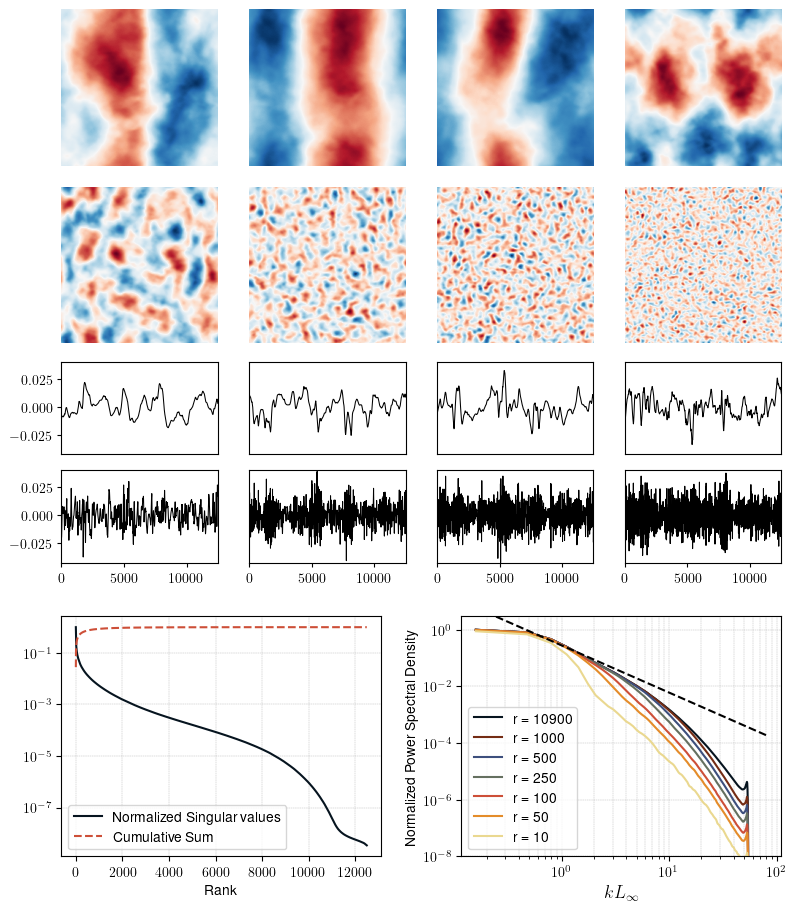

In [3]:
case='S2'                       
plane=1                                 #horizontal plane of choice -- for case S1: planes between [1, 57], for S2: [1,76]
rank_list=[10900,1000,500,250,100,50,10] #list of ranks for the spectral plot
labels=rank_list                        #make string labels for the ranks for the spectral plot
mode_list = [0,1,2,9,49,249,499,999]    #list of rank modes for the plots of U and V modes


plot_results.plot_svd_and_spectra_DNS(case,plane, rank_list, mode_list, labels)

### Compressing Experimental Case E2

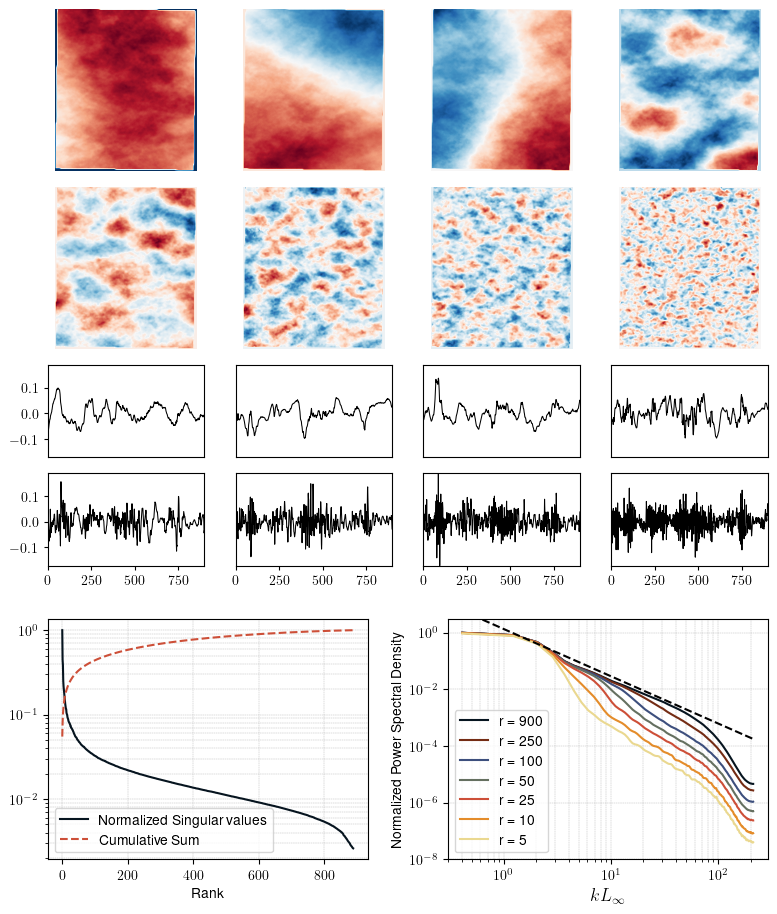

In [2]:
case='E2'
plane=3
rank_list = [900,250,100,50,25,10,5]
labels=rank_list
mode_list=[0,1,2,9,24,49,99,249]
ensembles=[3]

plot_results.plot_svd_and_spectra_exp(case,plane, rank_list, mode_list, labels, ensembles)

## **Run SHRED**

When executing SHRED, we decide how many planes to feed in, what case to run for, what rank compression we apply to the input, how many sensor to use and how many SHRED ensemble runs we want. 

### SHRED DNS CASE S2

Here we run SHRED for only two planes (plane 10, roughly $0.2 L_{\infty}$ deep, and plane 70 roughly $1.8 L_{\infty}$ deep). We run only one ensemble case for this test case

rank:  250 
 SHRED ensemble:  100
sensor_loc:  [47293 38762 59528]
test indices:  [   11    18    31 ... 12426 12434 12445]
Training epoch 1
Error tensor(0.2634, device='cuda:0')
Training epoch 20
Error tensor(0.2615, device='cuda:0')
Training epoch 40
Error tensor(0.2464, device='cuda:0')
Training epoch 60
Error tensor(0.2174, device='cuda:0')
Training epoch 80
Error tensor(0.1917, device='cuda:0')
Training epoch 100
Error tensor(0.1729, device='cuda:0')
Training epoch 120
Error tensor(0.1622, device='cuda:0')
Training epoch 140
Error tensor(0.1574, device='cuda:0')
Training epoch 160
Error tensor(0.1534, device='cuda:0')
Training epoch 180
Error tensor(0.1701, device='cuda:0')
SHRED completed successfully!


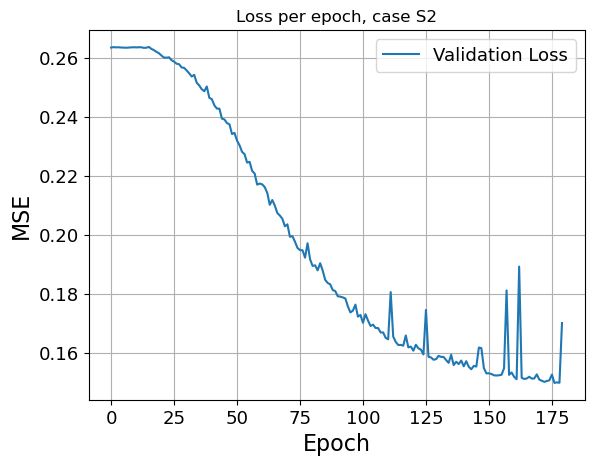

test error:  0.65929997


In [6]:
'''INPUT PARAMETERS'''
case='S2' 

full_planes=True                 #if all planes included, set this to True. 
vel_planes_selective = [10,70]      #else, we choose specific planes

num_sensors = 3   #number of sensors for surface measurement. Standard is 3.
ens_start=100 #start index for first SHRED ensemble (can be 0)
ens_end=100  #last index for SHRED ensemble
lags=52     #lags for the LSTM, standard is 52      
random_sampling=True    #if True, snapshots are randomly exctracted and separated to training, validation or testing 
                        #throughout the dataset. If False, a forecast is done (not fully functional as of now)


if case=='S1':
    vel_planes_all = np.arange(1,58)    #all planes for case S1
    r_vals = [225]                      #chosen rank for case S1
elif case=='S2':
    vel_planes_all = np.arange(1,77)    #all planes for case S2
    r_vals = [250]                      # chosen rank for case S2

if full_planes:
    vel_planes = vel_planes_all
else:
    vel_planes = vel_planes_selective


'''RUN ENSEMBLE OF SHRED'''
processdata.SHRED_ensemble_DNS(r_vals, num_sensors, ens_start, ens_end, vel_planes, 
                               lags, full_planes, random_sampling, case)

### SHRED Experimental case E2

(329400, 900)
rank:  100 
 SHRED ensemble:  100
sensor_loc:  [160083 168317 123732]
test indices:  [ 23  42  49  89 108 125 134 144 151 182 188 192 218 224 232 243 261 266
 272 279 294 305 308 325 335 343 361 381 398 407 419 440 454 466 481 493
 525 558 564 578 581 594 601 603 612 642 658 662 664 682 694 698 722 728
 730 752 761 766 774 781 794 799 827 845]
Training epoch 1
Error tensor(0.4689, device='cuda:0')
Training epoch 20
Error tensor(0.2715, device='cuda:0')
Training epoch 40
Error tensor(0.2716, device='cuda:0')
Training epoch 60
Error tensor(0.2716, device='cuda:0')
Training epoch 80
Error tensor(0.2709, device='cuda:0')
Training epoch 100
Error tensor(0.2706, device='cuda:0')
SHRED successfully done!


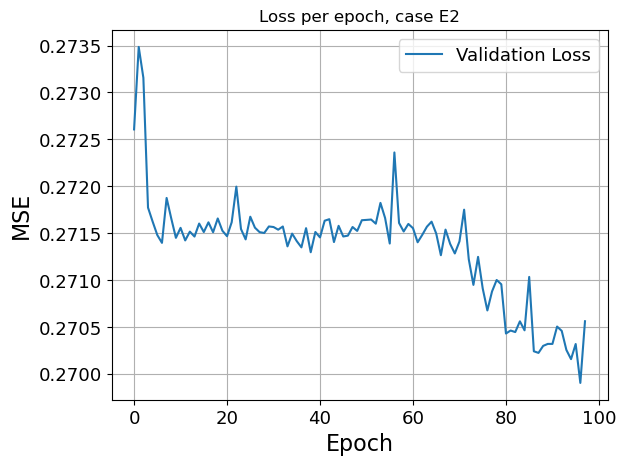

0.99250734


In [2]:
'''INPUT PARAMETERS'''

case = 'E2'

vel_planes = [2]
experimental_ens_list = [13]    #list of experimental ensembles to run for;
                                #NOTE: can be any from 1 to 20, except 4-10
r_vals = [100]    #chosen rank for cases E1 & E2 
num_sensors = 3 #number of sensors for surface measurement. Standard is 3.
ens_start=100   #start index for first SHRED ensemble (can be 0)
ens_end=100     #last index for SHRED ensemble
lags=52     #lags for the LSTM, standard is 52  
random_sampling=True    #if True, snapshots are randomly exctracted and separated to training, validation or testing 
                        #throughout the dataset. If False, a forecast is done (not fully functional as of now)


'''RUN ENSEMBLE OF SHRED'''
for k in range(len(vel_planes)):
    plane=vel_planes[k]
    planes = ['H395','H390', 'H375', 'H350', 'H300']
    exp_plane= planes[plane -1]
    
    for i in range(len(experimental_ens_list)):
        
        experimental_ens=experimental_ens_list[i]
        if experimental_ens > 10 or experimental_ens < 4:
            surf = utilities.get_normalized_surface_exp(case, plane, experimental_ens)

            processdata.SHRED_ensemble_exp(r_vals, num_sensors, surf, ens_start, ens_end, case, experimental_ens, lags, exp_plane=exp_plane, random_sampling=random_sampling)

# Plot and compare SHRED outputs

Now that we have SHRED results saved (the V matrix of the test images), we can calculate the full field matrix multiplication with pre-saved U and S matrices, to get reconstructed fields. We then compare this to the (uncompressed) ground truth and the compressed fields, for the surface elevation, as well as velocity fields below the surface. We plot this as a figure below:

### Compare case S2

plane  10
getting test images
test images extracted
plane  70
getting test images
test images extracted


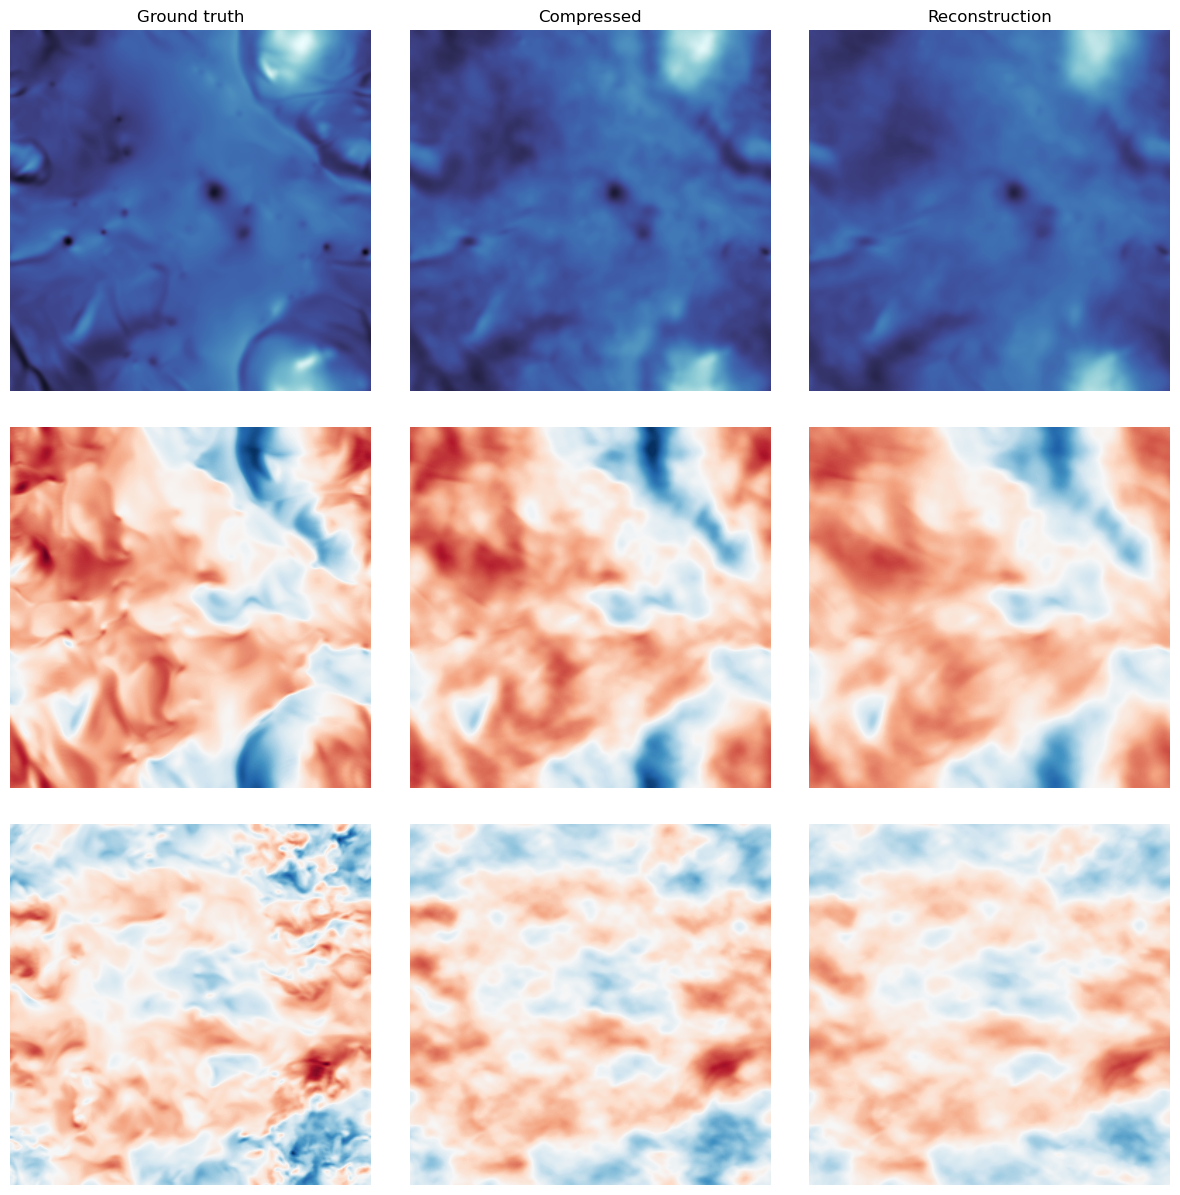

In [3]:

vel_planes = [10,70]#velocity planes to compare
rank = 250          #SVD rank used in the SHRED simulation
SHRED_ens=10        #what SHRED ensemble case to plot for
num_sensors=3       #standard is 3 sensors
test_snap_index=790 #what snapshot index in the testing data to plot
lags=52             #lags for the LSTM
forecast=False      #f the SHRED run is in forecast mode
add_surface=True    #if surface profile is to be included
full_planes=True    #if the SHRED run is coming from a full plane run, or specific planes only
case='S2'           #Simulation case


plot_results.plot_SHRED_comparison_DNS(rank, SHRED_ens, vel_planes, num_sensors, test_snap_index, 
                                        lags, forecast, add_surface, full_planes, case)

### Compare case E2

plane:  H390
load surface
getting test images
load velocity field, plane H390
test images extracted


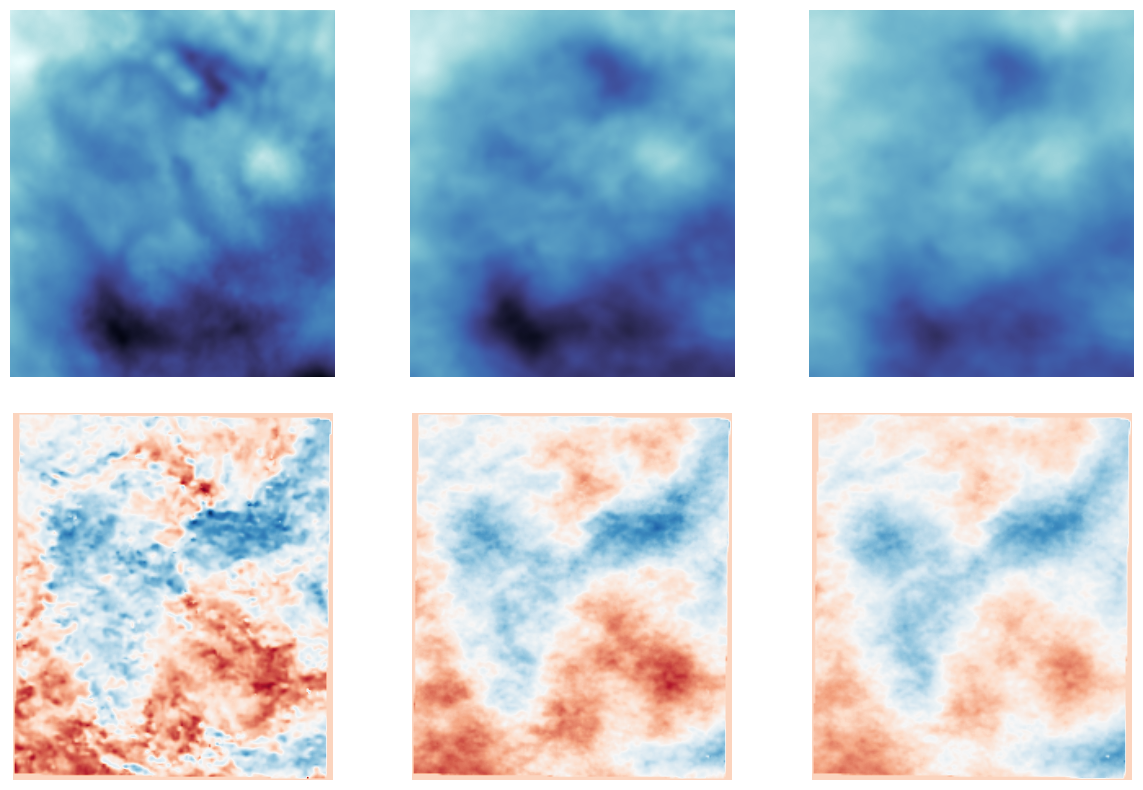

In [2]:

rank = 100              #SVD rank value used in the compression fed into SHRED
SHRED_ens=36            #what SHRED ensemble index to plot for
num_sensors=3
test_snap_index=54      #what snapshot index in the testing data to plot
lags=52                 #lags for the LSTM, must be correct to shift the extracted test images correctly
forecast=False          
add_surface=True        #include surface in the plot
full_planes=True        #True if SHRED training comes from a set of all planes, or selected planes only  
exp_case='E2'           #E1 or E2
experimental_ens = 3   #list of experimental ensembles to run for; #used in paper: experimental_ens=15
                             #NOTE: can be any from 1 to 20, except 4-10
plane_list = [2]        #plane 1 doesn't exist, only planes 2 (closest to surface) to 5 (deepest)

plot_results.plot_SHRED_comparison_exp(rank, exp_case, experimental_ens, SHRED_ens, plane_list, test_snap_index,None, None, 
                              num_sensors, lags=52, forecast=False, add_surface=add_surface)


# Calculate error metrics

The following cell runs and saves error metrics (RMS, NMSE, PSDE, SSIM & PSNR) for the SHRED reconstructions of the DNS case S2 and experimental case E2. **Note:** these are NOT used to plot error metrics, only to calculate and save

#### DNS case S2

In [ ]:
#NOTE: these following variables are only determined based on what parameters are used in saved SHRED runs

SHRED_ensembles = np.arange(100,101)    #list of SHRED runs to calculate for
vel_planes= [10,70] #np.arange(1,77)          #list of velocity planes 
r_vals = [250]                      #list of ranks
num_sensors = 3                    #number of sensors
DNS_case='S2'   
lags=52
forecast=False                  
full_planes_SHRED=True #whether to open SHRED for full planes (True), or for specific run with chosen planes (False) as given by vel_planes
                        #If True, but vel_planes is fewer planes than full length of planes, then these selected planes are calculated



#loop for iterating rank values 
for r in range(len(r_vals)):
    rank = r_vals[r]
    
    processdata.calculate_error_metrics(DNS_case, rank, vel_planes, num_sensors, SHRED_ensembles, lags, forecast, full_planes_SHRED)

#NOTE for running rank dependence analysis (appendix A):
    #run with extended r_vals list of a range of ranks (their SHRED runs must be saved first)
    # full_planes=False, and only for selected vel_planes

start SHRED ensemble looping
ensemble:  8
plane:  10
calc MSE
calc SSIM
ssim_vals:  0.7326987463220197
calc PSNR
PSNR val:  27.203213449361833
calc PSD
PSD error:  0.1915502064679523
plane:  70
calc MSE
calc SSIM
ssim_vals:  0.570588097194004
calc PSNR
PSNR val:  24.84056343204281
calc PSD
PSD error:  0.21509119871682006
saved successfully!


#### Experimental case E2

In [2]:
#NOTE: these following variables are only determined based on what parameters are used in saved SHRED runs
SHRED_ensembles = [10]#[10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
vel_planes=[2,3,4,5]
r_vals = [100]

num_sensors = 3
case='E2'
lags=52
forecast=False
full_planes_SHRED=False #whether to open SHRED for full planes (True), or for specific run with chosen planes (False) as given by vel_planes
                #If True, but vel_planes is fewer planes than full length of planes, then these selected planes are calculated

experimental_ens = [3]#[1,2,3, 11,12,13,14,15,16,17,18,19,20]

#loop for iterating rank values and sensor values
for r in range(len(r_vals)):
    rank = r_vals[r]

    processdata.calculate_error_metrics_exp(case, rank, vel_planes, num_sensors, SHRED_ensembles, experimental_ens, lags=52, forecast=False, full_planes=True)

start ensemble looping
ensemble:  10
plane:  2
Plane:  H390
load velocity field, plane H390
calc MSE
calc SSIM
ssim_vals:  0.46662728350963945
calc PSNR
PSNR val:  23.91901014178714
calc PSD
PSD val:  0.14242844878061592
plane:  3
Plane:  H375
load velocity field, plane H375
calc MSE
calc SSIM
ssim_vals:  0.434103671909298
calc PSNR
PSNR val:  23.475352446541464
calc PSD
PSD val:  0.16058577565774942
plane:  4
Plane:  H350
load velocity field, plane H350
calc MSE
calc SSIM
ssim_vals:  0.4239871738483496
calc PSNR
PSNR val:  23.383492330666172
calc PSD
PSD val:  0.25886883588889464
plane:  5
Plane:  H300
load velocity field, plane H300
calc MSE
calc SSIM
ssim_vals:  0.40371168687470826
calc PSNR
PSNR val:  22.872520635217633
calc PSD
PSD val:  0.23435385659508767
saved successfully!


Before running ensemble-averaged depth dependent error metric profiles, we also need to calculate the true RMS profiles of all four cases and save them. This is because it is used in the RMS plots. To do this, we can run this cell:

In [ ]:
dimT = 10900
DNS_case='S1'
vel_planes = np.arange(1,58)
rms_z_true = processdata.calc_RMS_profile_true(DNS_case, vel_planes, dimT)

dimT = 12500
DNS_case='S2'
vel_planes = np.arange(1,58)
rms_z_true = processdata.calc_RMS_profile_true(DNS_case, vel_planes, dimT)

dimT = 900
DNS_case='E1'
vel_planes = np.arange(2,6)
rms_z_true = processdata.calc_RMS_profile_true_exp(vel_planes, dimT, case, num_experimental_ensembles=1)

dimT = 900
DNS_case='E2'
vel_planes = np.arange(2,6)
rms_z_true = processdata.calc_RMS_profile_true_exp(vel_planes, dimT, case, num_experimental_ensembles=1)



# Plot ensemble-averaged depth-dependent error metric profiles

In the following cell, we plot the depth-dependent error metrics corresponding to Fig. 9 in the paper. The vertical profiles of depth-dependent metrics such as Normalized Mean Squared Error (NMSE), Power Spectral Density Error (PSDE), Structural Similarity Index Measure (SSIM) and Peak Signal-to-Noise Ratio (PSNR) are plotted. These are averaged across a range of SHRED ensemble runs. 

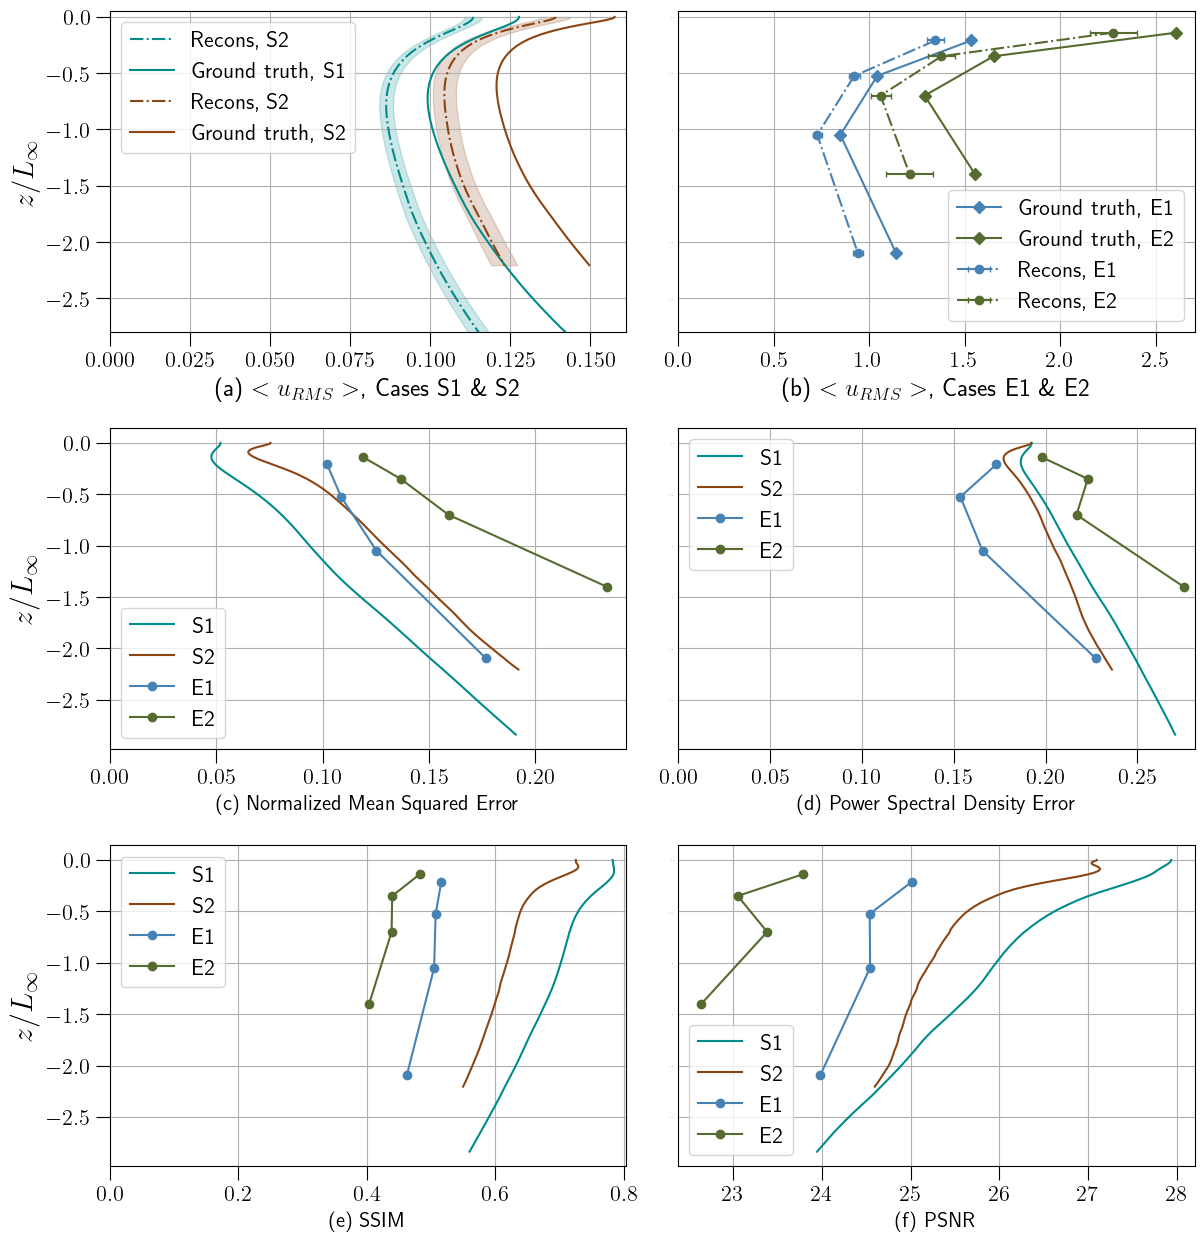

In [2]:

DNS_cases=['S1','S2']
exp_cases = ['E1', 'E2']


vel_planes_S1=np.arange(1,58)
vel_planes_S2=np.arange(1,77)
vel_planes_exp = [2,3,4,5]
full_planes_exp = True
full_planes=True
full_planes_error_basis=False

exp_ensembles_E1 = [1,2,3, 11,12,13,14,15,16,17,18,19,20]
exp_ensembles_E2 = [1,2,3, 11,12,13,14,15,16,17,18,19,20]


SHRED_ensembles_S1= np.arange(0,26)
SHRED_ensembles_S2= np.arange(0,26)
SHRED_ensembles_E1 = np.arange(10,40)
SHRED_ensembles_E2 = np.arange(10,40)

num_sensors=3
ranks = [225,250, 100,100]
forecast=False
colors=['darkcyan', 'saddlebrown', 'steelblue', 'darkolivegreen']
z_norm='int' # what length scale to normalize depth with : 'taylor', 'mixed', 'int' or None


plot_results.plot_depth_dependent_error_metrics(DNS_cases, exp_cases, ranks, colors, vel_planes_S1, vel_planes_S2, vel_planes_exp, num_sensors, 
                                                   SHRED_ensembles_S1,SHRED_ensembles_S2, SHRED_ensembles_E2, SHRED_ensembles_E2, exp_ensembles_E1, 
                                                   exp_ensembles_E2, forecast=False,full_planes=True, full_planes_exp=full_planes_exp, z_norm=z_norm)

## Calculate instantaneous vertical RMS profiles (Fig. 8)

First, we calculate every the vertical profile of the planar RMS velocity for all test snapshots given a SHRED ensemble case and other parameters. Then we plot, using a plotter. 

In [7]:
DNS_case='S2'
SHRED_ens = 0
rank = 250
num_sensors =3


processdata.calculate_instantaneous_rms_profile(DNS_case, SHRED_ens, rank, num_sensors)

(array([[0.16754464, 0.1645475 , 0.16051465, ..., 0.16595348, 0.16316348,
         0.15761379],
        [0.16753814, 0.16454205, 0.1605097 , ..., 0.16594297, 0.1631533 ,
         0.15760355],
        [0.16746937, 0.16448471, 0.16045978, ..., 0.1658485 , 0.16306119,
         0.15751306],
        ...,
        [0.12164787, 0.12074184, 0.11801477, ..., 0.16409662, 0.16186243,
         0.15831266],
        [0.12231834, 0.12171285, 0.120535  , ..., 0.16532137, 0.16278684,
         0.15818341],
        [0.12334071, 0.12257332, 0.12360387, ..., 0.16567147, 0.16306835,
         0.15775981]]),
 array([[0.14668705, 0.15103192, 0.15835998, ..., 0.15828803, 0.15689357,
         0.14464859],
        [0.1466783 , 0.1510225 , 0.1583346 , ..., 0.15829054, 0.15689601,
         0.14465036],
        [0.14662906, 0.15097457, 0.15831626, ..., 0.15820344, 0.15680967,
         0.14457081],
        ...,
        [0.10009258, 0.10230753, 0.10624722, ..., 0.14531207, 0.1440571 ,
         0.13303686],
        [0.1

In [3]:
exp_case='E2'
experimental_ens=3
SHRED_ens = 3
rank=100
num_sensors=3


rms_gt, rms_recons = processdata.calculate_instantaneous_rms_profile_exp(exp_case, experimental_ens, SHRED_ens, rank, num_sensors)

plane:  2
plane:  H390
load velocity field, plane H390
plane:  3
plane:  H375
load velocity field, plane H375
plane:  4
plane:  H350
load velocity field, plane H350
plane:  5
plane:  H300
load velocity field, plane H300


#### Plot instantaneous vertical RMS profiles 

0
1
2


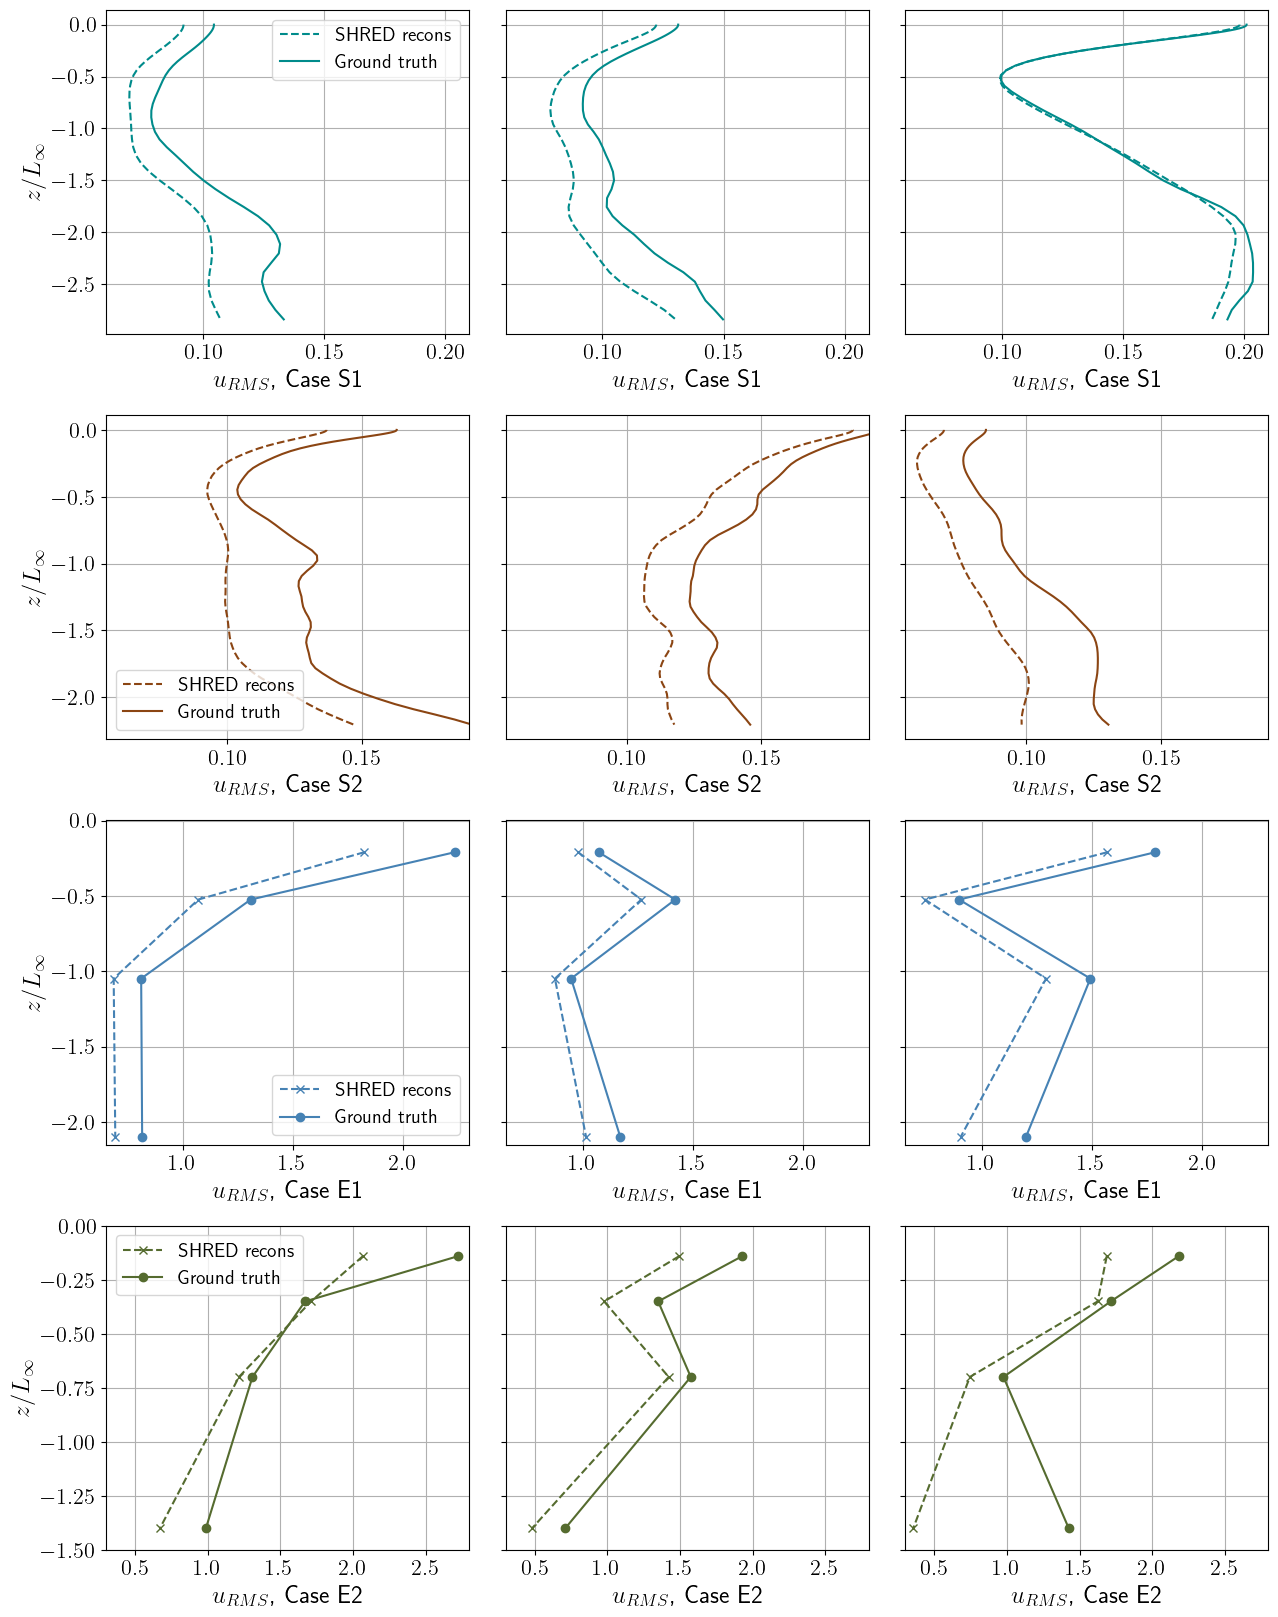

In [2]:

SHRED_ens_DNS = 0
ranks = [225,250, 100,100]
num_sensors =3
snap_indices_DNS = [20,150,300]
colors = ['peru', 'forestgreen', 'midnightblue']
colors=['darkcyan', 'saddlebrown', 'steelblue', 'darkolivegreen']
experimental_ens=3
SHRED_ens_exp=3
snap_indices_exp = [5,25,50]
labels= [['Ground truth', 'SHRED recons'], ['Ground truth 2', 'recons 2'], ['Ground truth 3', 'recons 3']]
plot_results.plot_instantaneous_RMS(experimental_ens, SHRED_ens_DNS, SHRED_ens_exp, snap_indices_DNS, snap_indices_exp, ranks, num_sensors, colors, labels, z_norm='int')

# Calculate and plot planar RMS time series of ground truth vs reconstruction

For a visual representation of the temporal performance of SHRED, we plot the time series of chosen error metrics for test snapshots. Options are the u RMS (the plotter function will plot both ground truth, as black solid line, and reconstruction, as blue dashed line), MSE, PSD error, SSIM or PSNR. Fig. 10 in paper, i.e. the u RMS of ground truth and reconstruction for all cases, for a representative SHRED run, and planes at around $0.14L_{\infty}-0.20L_{\infty}$ is reproduced below.

start ensemble looping
start ensemble looping
plane:  2
Plane:  H390
load velocity field, plane H390
plane:  2
Plane:  H390
load velocity field, plane H390
RMS correlations: 
S1: 0.9460534473474917 
S2: 0.9566950936436954 
E1: 0.9403693114954148 
E2: 0.8952446504151652


e:\Users\krissmoe\Documents\SHRED-turbulence-sensing\plot_results3.py:1280: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


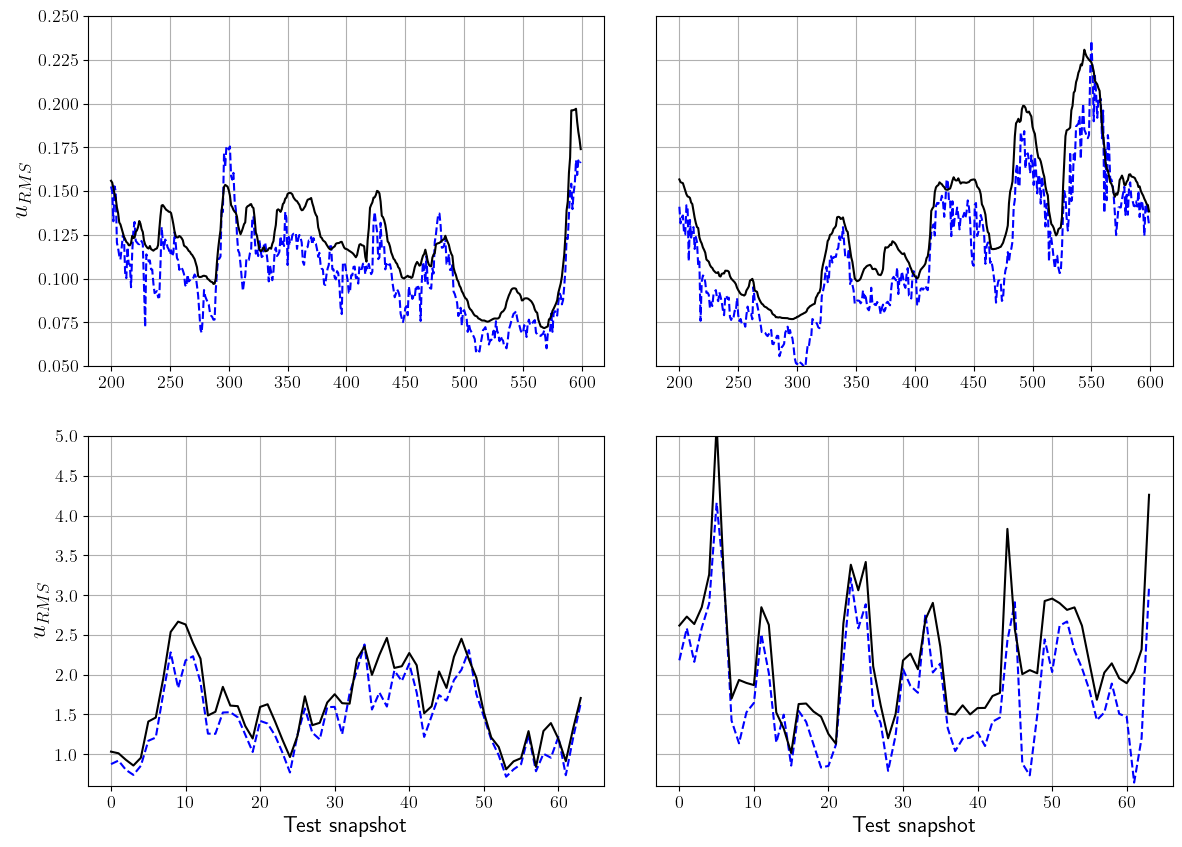

In [6]:
ranks = [225, 250, 100, 100]
vel_planes = [20,20,2,2]
SHRED_ensembles = [14, 14,33,33]          #SHRED ensemle index for each of the cases S1, S2, E1, E2
experimental_ensembles = [13, 13]   #experimental ensemble to choose. Pick only one!
metric='rms'                   #'rms', 'mse', 'psd', 'ssim' or 'psnr'

plot_results.plot_time_series_error_metrics(ranks, vel_planes, SHRED_ensembles, experimental_ensembles,metric)

#### Deeper plane analysis:

start ensemble looping
shape fft:  (1064, 127)
start ensemble looping
shape fft:  (1224, 255)
plane:  5
Plane:  H300
load velocity field, plane H300
shape fft:  (64, 261)
plane:  5
Plane:  H300
load velocity field, plane H300
shape fft:  (64, 261)
RMS correlations: 
S1: 0.7318469718373382 
S2: 0.5086626514919319 
E1: 0.9511110301087986 
E2: 0.8681960584300972


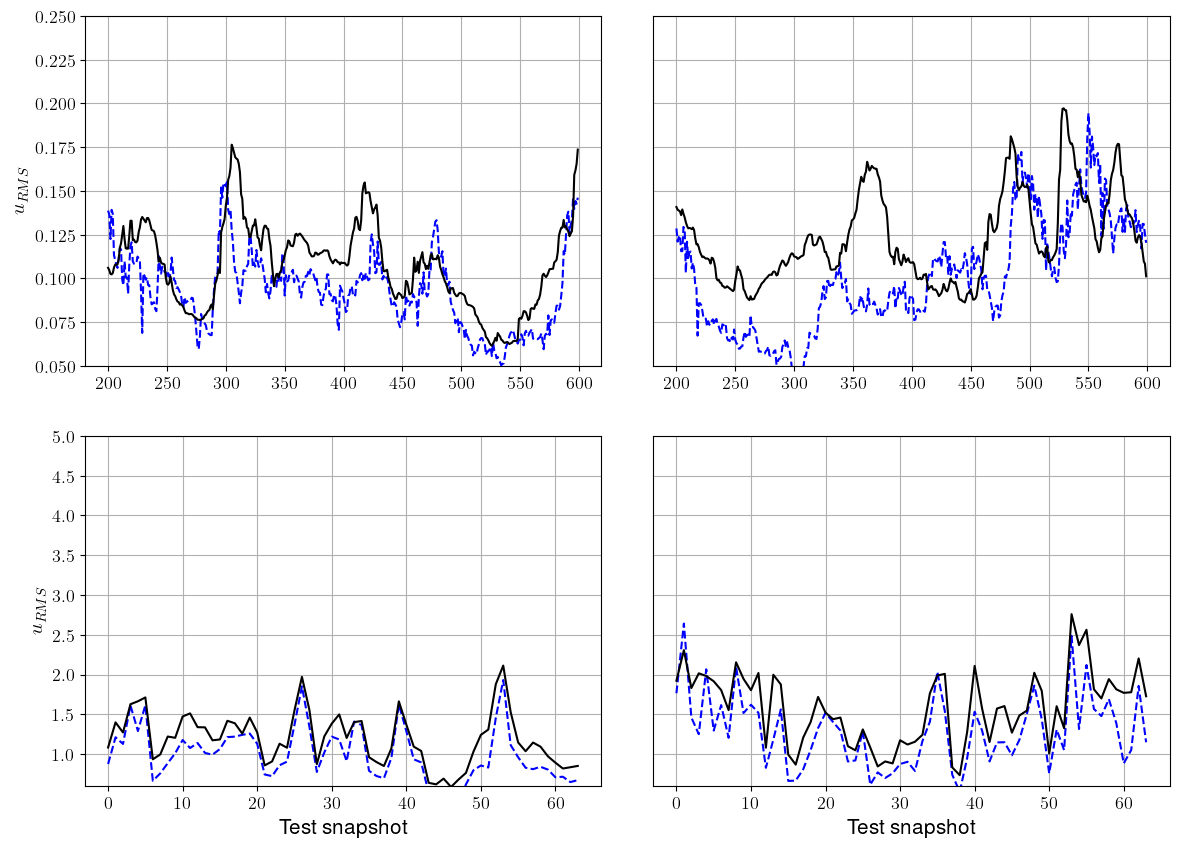

In [ ]:

ranks = [225, 250, 100, 100]
vel_planes = [40,50,5,5]
SHRED_ensembles = [14, 14,33,33]          #SHRED ensemle index for each of the cases S1, S2, E1, E2
experimental_ensembles = [13, 13]   #experimental ensemble to choose. Pick only one!
metric='rms'                   #'rms', 'mse', 'psd', 'ssim' or 'psnr'

plot_results.plot_time_series_error_metrics(ranks, vel_planes, SHRED_ensembles, experimental_ensembles,metric)

# Plot PSD spectra for ground truth vs reconstruction 

In the following cell, we plot and replicate Fig. 11, of PSD spectra of ground truth and SHRED reconstructions for all cases, at a specified depth. 

load velocity field, plane H300
cutoff normalized wavenumber k for case E1:  4.573364477898244
load velocity field, plane H300
cutoff normalized wavenumber k for case E2:  6.097819303864327
cutoff normalized wavenumber k for case S1:  3.601718349655818
cutoff normalized wavenumber k for case S2:  3.6588935222508248


e:\Users\krissmoe\Documents\SHRED-turbulence-sensing\plot_results3.py:1496: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


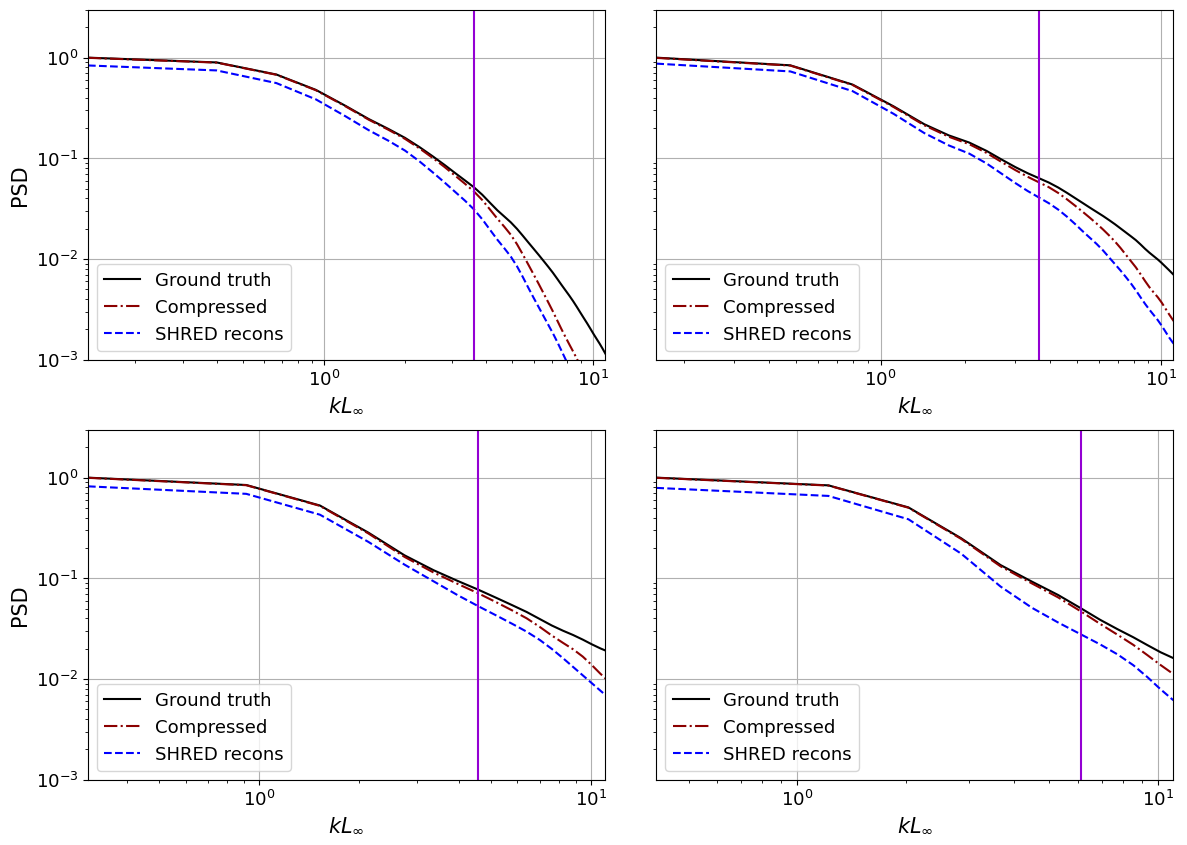

In [2]:
vel_planes = [40,50,5,5]
ranks = [225, 250, 100, 100]
SHRED_ensembles=[7,7, 33, 33]
experimental_ensembles = [13, 13]
ranks = [225, 250, 100, 100]
num_sensors=3

plot_results.plot_psd_all_cases(vel_planes, SHRED_ensembles, experimental_ensembles, ranks, num_sensors)

##### Spectra near-surface

load velocity field, plane H390
cutoff normalized wavenumber k for case E1:  4.573364477898244
load velocity field, plane H390
cutoff normalized wavenumber k for case E2:  6.097819303864327
cutoff normalized wavenumber k for case S1:  3.601718349655818
cutoff normalized wavenumber k for case S2:  3.6588935222508248


e:\Users\krissmoe\Documents\SHRED-turbulence-sensing\plot_results3.py:1496: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


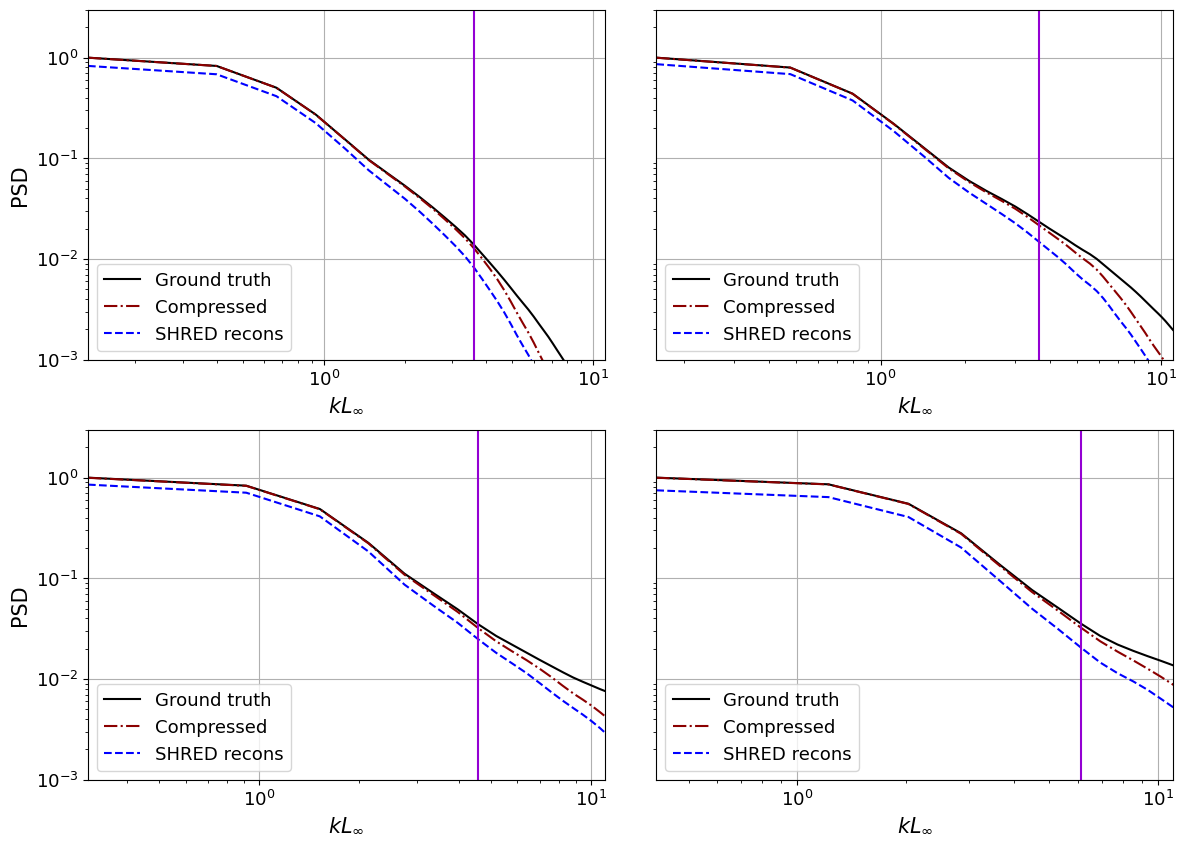

In [3]:
vel_planes = [20,20,2,2]
ranks = [225, 250, 100, 100]
SHRED_ensembles=[7,7, 33, 33]
experimental_ensembles = [13, 13]
ranks = [225, 250, 100, 100]
num_sensors=3

plot_results.plot_psd_all_cases(vel_planes, SHRED_ensembles, experimental_ensembles, ranks, num_sensors)

# Plot PSD spectra dependence on rank values

To illustrate the loss from SVD compression versus SHRED reconstruction, we plot the PSD spectra dependence on rank values.

rank:  25
rank:  125
rank:  250
rank:  325
rank:  400
rank:  450


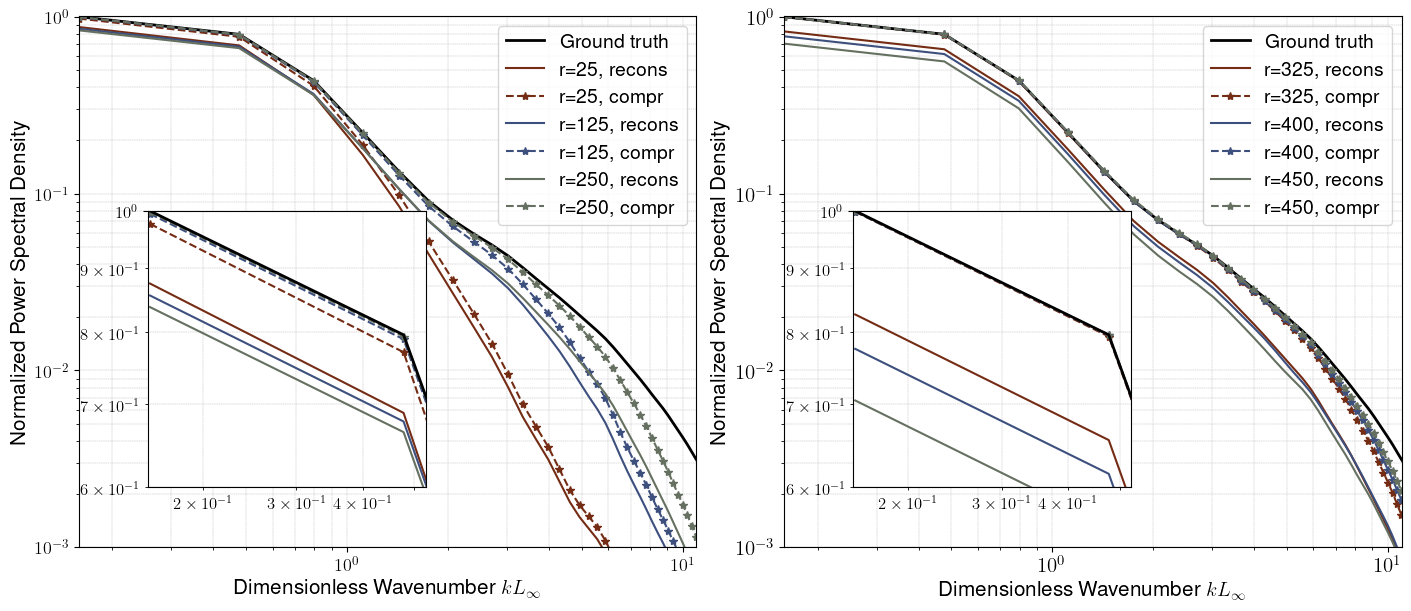

In [5]:


DNS=True
case = 'S2'
vel_planes = [1,6,11,16,21,26,31,36,41,46,51,56,61,66,71,76]
plane_index = 5 #plane 26
num_sensors = 3
SHRED_ens = 9
r_vals = np.array([25,125,250,325,400, 450])
experimental_ens=None
split_rank = 325
plot_results.plot_psd_rank_comparison_with_SHRED(r_vals, case, DNS, vel_planes, plane_index, num_sensors, SHRED_ens, experimental_ens, split_rank)

rank:  25
load velocity field, plane H300
rank:  50
load velocity field, plane H300
rank:  100
load velocity field, plane H300
rank:  150
load velocity field, plane H300
rank:  200
load velocity field, plane H300
rank:  250
load velocity field, plane H300


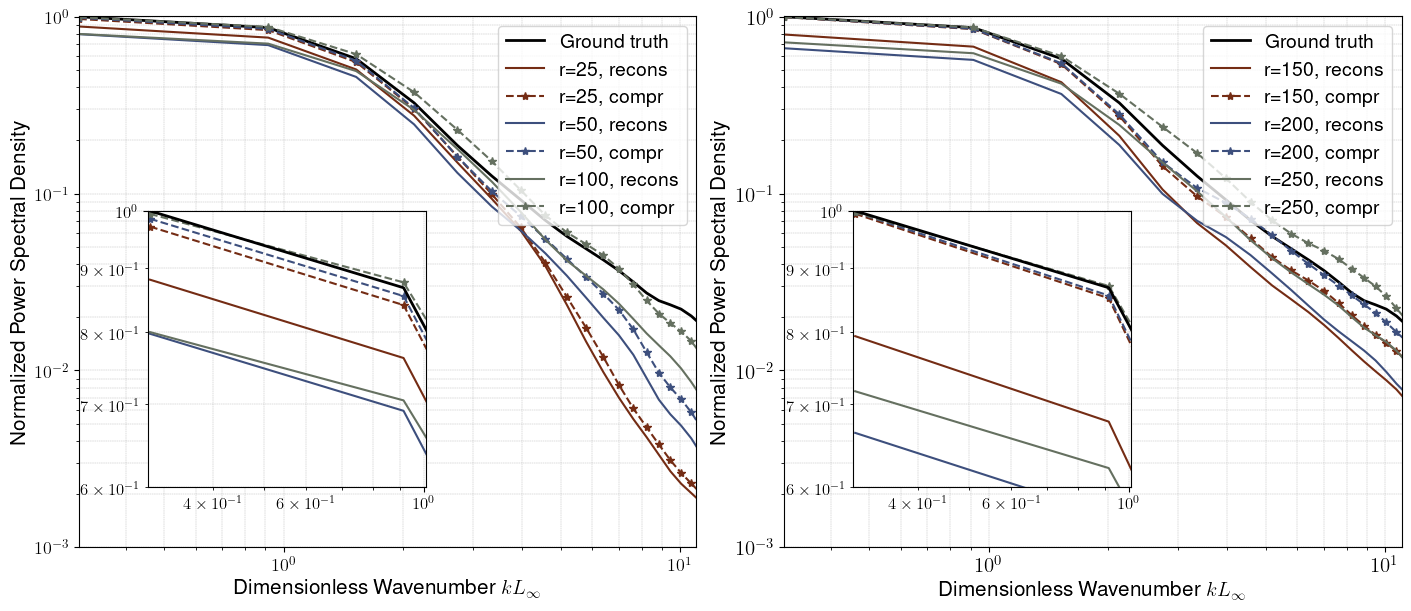

In [ ]:
DNS=False
case = 'E1'
vel_planes = [2,3,4,5]
plane_index = 4 
num_sensors = 3
SHRED_ens = 9
r_vals = np.array([25,50,100,150,200, 250])
experimental_ens=3
split_rank = 150
plot_results.plot_psd_rank_comparison_with_SHRED(r_vals, case, DNS, vel_planes, plane_index, num_sensors, SHRED_ens, experimental_ens, split_rank)

# Plotting error metric dependence on rank values

We reproduce Fig. 13, the 4-panel figure showing how the chosen SHRED reconstruction error metrics (MSE, PSDE, SSIM & PSNR) vary with the SVD rank.

### Case S1

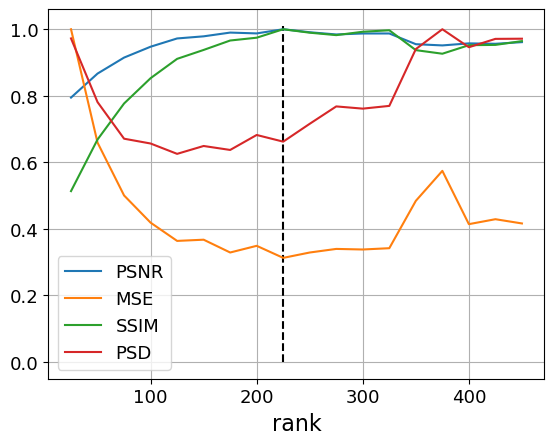

In [2]:
DNS_case='S1'
vel_planes = [1,6,11,16,21,26,31,36,41,46,51,56,61,66,71,76]
vel_planes=[1,6,11,16,21,26,31,36,41,46,51,56]
r_vals = np.array([25,50,75,100,125,150,175,200,225,250,275,300,325,350,375, 400,425,450])
SHRED_ensembles = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15]
sensor_vals=[3]
optimal_var_val = 225 #optimal value of rank r or num_sensor, only used to mark with a dashed line in plot
full_planes=False #would always be False for DNS, but often True for Teetank
r_analysis=True #True if analysing ranks, False if analysing sensors

plot_results.plot_parameter_analysis_DNS(DNS_case, r_vals, vel_planes, sensor_vals, optimal_var_val, SHRED_ensembles, full_planes, r_analysis, singular_val_energy=False, comp_rate=False)

### Case S2

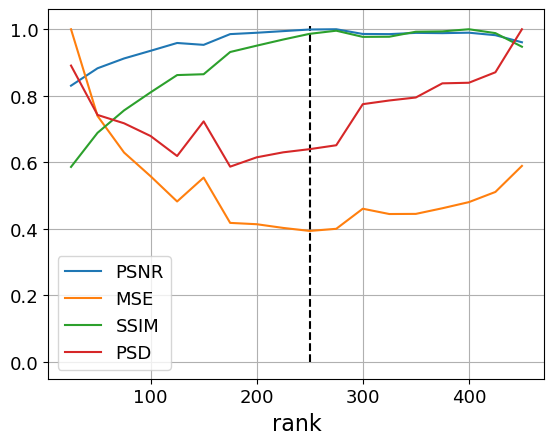

In [3]:
DNS_case='S2'
vel_planes = [1,6,11,16,21,26,31,36,41,46,51,56,61,66,71,76]
r_vals = np.array([25,50,75,100,125,150,175,200,225,250,275,300,325,350,375, 400,425,450])
SHRED_ensembles = [1,3,4,7,9,8]
sensor_vals=[3]
optimal_var_val = 250 #optimal value of rank r or num_sensor, only used to mark with a dashed line in plot
full_planes=False #would always be False for DNS, but often True for Teetank
r_analysis=True #True if analysing ranks, False if analysing sensors

plot_results.plot_parameter_analysis_DNS(DNS_case, r_vals, vel_planes, sensor_vals, optimal_var_val, SHRED_ensembles, full_planes, r_analysis, singular_val_energy=False, comp_rate=False)

### Case E1

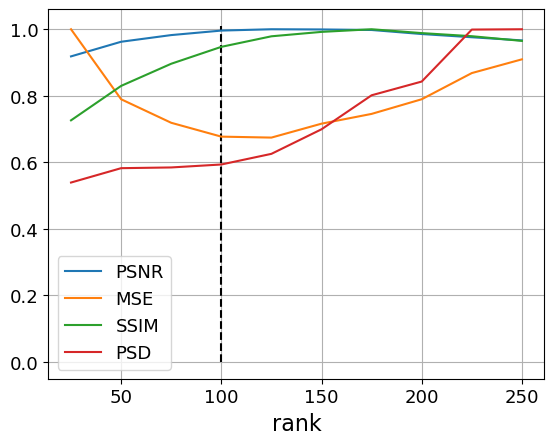

In [2]:
exp_case='E1'
vel_planes=[2,3,4,5]
r_vals = np.array([25,50,75,100,125,150,175,200,225,250])
SHRED_ensembles = [1,2,3,4,5,6,7,8,9,10] #leave 4 and 1
sensor_vals=[3]
optimal_var_val = 100 #optimal value of rank r or num_sensor, only used to mark with a dashed line in plot
full_planes=True #would always be False for DNS, but often True for Teetank
r_analysis=True #True if analysing ranks, False if analysing sensors
experimental_ens = 3

plot_results.plot_parameter_analysis_exp(exp_case, [experimental_ens], r_vals, vel_planes, sensor_vals, optimal_var_val, SHRED_ensembles, full_planes, r_analysis, singular_val_energy=False, comp_rate=False)

### Case E2

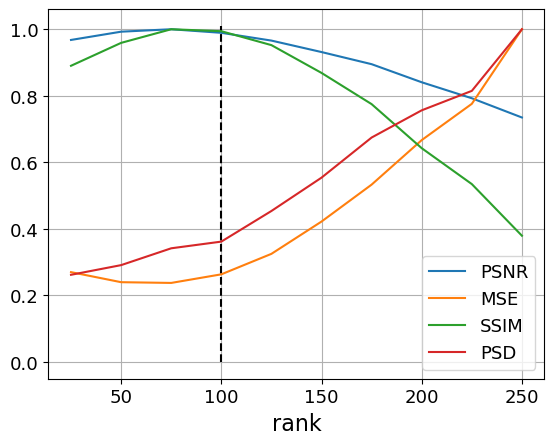

In [ ]:
exp_case='E2'
vel_planes=[2,3,4,5]
r_vals = np.array([25,50,75,100,125,150,175,200,225,250])
SHRED_ensembles = [1,2,3,4,5,6,7,8,9,10] #leave 4 and 1
sensor_vals=[3]
optimal_var_val = 100 #optimal value of rank r or num_sensor, only used to mark with a dashed line in plot
full_planes=True #would always be False for DNS, but often True for T-tank
r_analysis=True #True if analysing ranks, False if analysing sensors
experimental_ens = 3

plot_results.plot_parameter_analysis_exp(exp_case, [experimental_ens], r_vals, vel_planes, sensor_vals, optimal_var_val, SHRED_ensembles, full_planes, r_analysis, singular_val_energy=False, comp_rate=False)
